## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from datetime import timedelta
import collections

In [2]:
tf.__version__

'0.12.1'

In [3]:
# We know that MNIST images are 28 pixels in each dimension.
img_hieght = 22

img_width = 30
# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_hieght * img_width

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_hieght, img_width)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 62

In [4]:
import re, os, cv2
from glob import glob

def create_argmax(folder_name):
    index = int(re.search('Sample(.*)', folder_name).group(1)) - 1
    arr = np.zeros(num_classes)
    arr[index] = 1
    return arr

def cvt_img2np(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape(660).astype(np.float32, copy=False)    
    
print(create_argmax('Sample001'))


#dir(re.match('[0-9]', text))

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.]


In [5]:

import cv2
i = 0
def get_dataset():
    DATASET_LOCATION = '/home/aspire/Downloads/RBL/English/Hnd/Img'
    hcr = {'data':[], 'labels':[], 'cls':[]}
    for folder in glob(DATASET_LOCATION + '/*'):
            if os.path.isdir(folder):            
                for img_path in glob(folder + '/*.png'):                
                    hcr.get('data').append(cvt_img2np(img_path))
                    hcr.get('labels').append(create_argmax(folder))
                    hcr.get('cls').append(int(folder[-3:]))
    print('read completed')
    # shuffle data
    permutate = np.random.permutation(len(hcr.get('data')))
    return {k1:v1[permutate] for k1, v1 in {k: np.array(v) for k, v in hcr.items()}.items()}

hcr = get_dataset()

ran_iterations = 0
def get_next_batch(count):
    global ran_iterations
    data = (np.squeeze(hcr.get('data')[ran_iterations: ran_iterations + count]), np.asarray(hcr.get('labels')[ran_iterations: ran_iterations + count]))
    ran_iterations += count
    return data

read completed


In [6]:

img = hcr.get('data')[0]
# img  = np.array(list(map(lambda x: 100 if x == 0 else 0, img)))


# from IPython.display import Image
# cv2.imwrite('/tmp/test.png', img.reshape((22, 30)))
# Image(filename='/tmp/test.png')

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

### Plot a few images to see if data is correct

In [8]:
# Get the first images from the test-set.
images = hcr.get('data')[1000:1009]

# Get the true classes for those images.
cls_true = hcr.get('cls')[1000:1009]

# Plot the images and labels using our helper-function above.
#plot_images(images=images, cls_true=cls_true)

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [10]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [11]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [12]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

The second variable that must be optimized is called `biases` and is defined as a 1-dimensional tensor (or vector) of length `num_classes`.

In [13]:
biases = tf.Variable(tf.zeros([num_classes]))

### Model

In [14]:
logits = tf.matmul(x, weights) + biases

In [15]:
y_pred = tf.nn.softmax(logits)

In [16]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

In [18]:
cost = tf.reduce_mean(cross_entropy)

In [19]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [21]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

In [22]:
session = tf.Session()

In [23]:
session.run(tf.global_variables_initializer())

#### Load test dataset

In [24]:

hcr_test_data = get_dataset()
feed_dict_test = {
                  x: hcr_test_data.get('data'),
                  y_true: hcr_test_data.get('labels'),
                  y_true_cls: hcr_test_data.get('cls')
                 }

read completed


In [25]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

Function for performing a number of optimization iterations so as to gradually improve the `weights` and `biases` of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [30]:

total_iterations = 0

def optimize(num_iterations):
    global total_iterations    
    x_batch, y_true_batch = get_next_batch(num_iterations)  
    
    print(collections.Counter(list(map(lambda x: np.argmax(x), y_true_batch))))
    
    if len(x_batch):
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.

        session.run(optimizer, feed_dict=feed_dict_train)
        
        total_iterations += num_iterations                
    else: 
        print('Not running')
        
        

In [27]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = hcr.get('data')[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    print(collections.Counter(cls_pred))
    # Get the true classes for those images.
    cls_true = hcr.get('cls')[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [28]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

0
Counter({3: 113, 0: 106, 2: 105, 8: 105, 6: 103, 5: 96, 9: 96, 1: 95, 7: 93, 4: 88})
Accuracy on test-set: 9.5%


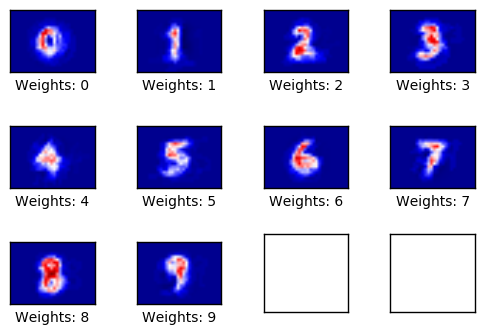

In [31]:
print(ran_iterations)
optimize(num_iterations=1000)
print_accuracy()
plot_weights()

Counter({8: 4440, 0: 200, 6: 180, 3: 70, 2: 40, 7: 40, 5: 10})


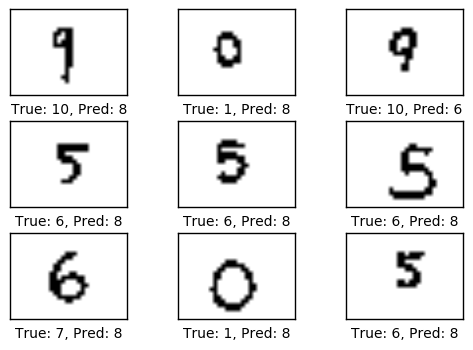

In [32]:
plot_example_errors()